In [4]:
import gym 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
import time
import numpy as np

from policy_gradients import PolicyGradients, Policy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

#env = gym.make('Pendulum-v1')
env = gym.make('CartPole-v1')

continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_states = env.observation_space.shape[0]
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

using cpu!
device: cpu


In [5]:
def perform_single_rollout(env, agent, episode_nb, render=False):

    # Modify this function to return a tuple of numpy arrays containing (observations, actions, rewards).
    # (np.array(obs), np.array(acs), np.array(rws))
    # np.array(obs) -> shape: (time_steps, nb_obs)
    # np.array(acs) -> shape: (time_steps, nb_acs) if actions are continuous, (time_steps,) if actions are discrete
    # np.array(rws) -> shape: (time_steps,)

    ob_t = env.reset()
    
    done = False
    episode_reward = 0
    nb_steps = 0
    
    obs, acs, rws = [], [], []

    while not done:

        if render:
            env.render()
            time.sleep(1. / 60)

        action = agent.select_action(ob_t) # cambiar a que solo reciba la accion?

        ob_t1, reward, done, _ = env.step(action)

        ob_t = np.squeeze(ob_t1) # <-- may not be needed depending on gym version
        episode_reward += reward
        
        nb_steps += 1

        obs.append(ob_t)
        acs.append(action)
        rws.append(reward)

        if done:
            
            obs = np.array(obs)
            acs = np.array(acs)
            rws = np.array(rws)
            
            assert obs.shape == (nb_steps, dim_states), 'shape of np.array(obs) is not (time_steps, nb_obs)'
            if continuous_control:
                assert acs.shape == (nb_steps, dim_actions), 'shape of np.array(acs) is not (time_steps, nb_acs)'
            else:
                assert acs.shape == (nb_steps,), 'shape of np.array(acs) is not (time_steps,)'
            assert rws.shape == (nb_steps,), 'shape of np.array(rws) is not (time_steps,)'
            
            return obs, acs, rws
        
        
#env = gym.make('Pendulum-v1')
env = gym.make('CartPole-v1')
continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_states = env.observation_space.shape[0]
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

agent = PolicyGradients(dim_states = dim_states, dim_actions = dim_actions, lr = 1e-3, gamma = .99, 
                        continuous_control = continuous_control)

perform_single_rollout(env, agent, 1)

(array([[ 0.03822616, -0.1836455 ,  0.01824644,  0.3301227 ],
        [ 0.03455325,  0.01121202,  0.0248489 ,  0.04324923],
        [ 0.03477749, -0.18425728,  0.02571388,  0.34366748],
        [ 0.03109234,  0.0104896 ,  0.03258723,  0.05920279],
        [ 0.03130214,  0.20512952,  0.03377129, -0.22302315],
        [ 0.03540472,  0.39975291,  0.02931082, -0.50486493],
        [ 0.04339978,  0.5944498 ,  0.01921353, -0.78816867],
        [ 0.05528878,  0.39906928,  0.00345015, -0.48950353],
        [ 0.06327017,  0.20389883, -0.00633992, -0.19573525],
        [ 0.06734814,  0.00886814, -0.01025462,  0.09494098],
        [ 0.06752551,  0.20413555, -0.0083558 , -0.20095955],
        [ 0.07160822,  0.399376  , -0.01237499, -0.49626657],
        [ 0.07959574,  0.59467024, -0.02230033, -0.7928237 ],
        [ 0.09148914,  0.79009116, -0.0381568 , -1.0924379 ],
        [ 0.10729096,  0.9856945 , -0.06000556, -1.3968447 ],
        [ 0.12700486,  1.1815093 , -0.08794245, -1.7076694 ],
        

In [8]:
def sample_rollouts(env, agent, training_iter, min_batch_steps):

    sampled_rollouts = []
    total_nb_steps = 0
    episode_nb = 0
    
    while total_nb_steps < min_batch_steps:

        episode_nb += 1
        #render = training_iter%10 == 0 and len(sampled_rollouts) == 0 # Change training_iter%10 to any number you want
        render = False

        # Use perform_single_rollout to get data 
        # Uncomment once perform_single_rollout works.
        # Return sampled_rollouts
        
        """
        sample_rollout = perform_single_rollout(env, agent, episode_nb, render=render)
        total_nb_steps += len(sample_rollout[0])

        sampled_rollouts.append(sample_rollout)
        """
        
        sample_rollout = perform_single_rollout(env, agent, episode_nb, render=render)
        total_nb_steps += len(sample_rollout[0])

        sampled_rollouts.append(sample_rollout)
        
    return sampled_rollouts

In [9]:
_use_reward_to_go = False
_use_baseline = False
_gamma = 0.99

def estimate_returns(rollouts_rew):
    estimated_returns = []
    for rollout_rew in rollouts_rew:
            
        if _use_reward_to_go:
            # only for part 2
            estimated_return = None
        else:
            estimated_return = [rollout_rew[t] * (_gamma ** t) for t in range(len(rollout_rew))]
        
        estimated_returns = np.concatenate([estimated_returns, estimated_return])

    if _use_baseline:
        # only for part 2
        average_return_baseline = None
        # Use the baseline:
        #estimated_returns -= average_return_baseline

    return np.array(estimated_returns, dtype=np.float32)

In [10]:
#env = gym.make('Pendulum-v1')
env = gym.make('CartPole-v1')
continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_states = env.observation_space.shape[0]
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

training_iterations = 1000
min_batch_steps = 5000

policy = Policy(dim_states=dim_states, dim_actions=dim_actions, continuous_control=continuous_control).to(device)

agent = PolicyGradients(dim_states = dim_states, dim_actions = dim_actions, lr = 1e-3, gamma = .99, 
                        continuous_control = continuous_control)

optimizer = torch.optim.Adam(params = policy.parameters(), lr = 1e-3)

output = sample_rollouts(env, agent, training_iter=training_iterations, min_batch_steps=min_batch_steps)

sampled_obs = [output[i][0] for i in range(len(output))]
sampled_acs = [output[i][1] for i in range(len(output))]
sampled_rew = [output[i][2] for i in range(len(output))]

rewards = sampled_rew[0]
gamma = 0.99

estimated_returns = estimate_returns(sampled_rew)
estimated_returns.shape

(5029,)

In [11]:
from collections import deque

rewards = [1, 1, 1]

estimated_return = deque() # for efficiency
n_steps = len(rewards) # steps of rollout

for t in range(n_steps)[::-1]:
    disc_return_t = estimated_return[0] if len(estimated_return) > 0 else 0
    estimated_return.appendleft(disc_return_t * gamma + rewards[t]) # pi_t = pi_{t+1} + r_t
    
list(estimated_return)

[2.9701, 1.99, 1.0]

In [12]:
rollout_obs = np.concatenate(sampled_obs)
rollout_acs = np.concatenate(sampled_acs)

rollout_obs = torch.from_numpy(rollout_obs).to(device)
rollout_acs = torch.from_numpy(rollout_acs).to(device)

if continuous_control:
    mean = policy(rollout_obs).to(device)
    std = torch.exp(policy._log_std).to(device)
    distr = Normal(mean, std) # 200 mean, 1 std
else:
    logits = policy(rollout_obs) #.cpu()
    distr = Categorical(logits = logits)

log_probs = distr.log_prob(rollout_acs) # return log_prob for each pair mean-action
#log_probs = log_probs.squeeze()

#loss =  - log_probs * torch.from_numpy(estimated_returns).to(device)

#loss = loss.mean()

#optimizer.zero_grad()
#loss.backward()
#optimizer.step()

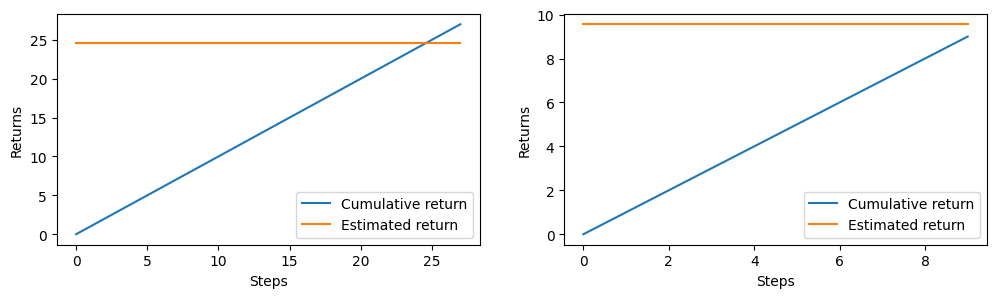

In [15]:
import gym
from policy_gradients import PolicyGradients
from train_agent import perform_single_rollout, sample_rollouts

if __name__ == '__main__':
    
    environments = ['CartPole-v1', 
                    #'Pendulum-v1',
                    ]
    for environment in environments:
        
        for _ in range(10):
        
            env = gym.make(environment)
            dim_states = env.observation_space.shape[0]
            continuous_control = isinstance(env.action_space, gym.spaces.Box)
            dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n
            
            policy_gradients_agent = PolicyGradients(dim_states=dim_states, 
                                                    dim_actions=dim_actions, 
                                                    continuous_control=continuous_control,
                                                    lr = 5e-3,
                                                    gamma = .99,
                                                    )

            # test for perform_single_rollout
            single_rollout = perform_single_rollout(env = env, agent = policy_gradients_agent, episode_nb = 1)
            
            # test for sample_rollouts
            sampled_rollouts = sample_rollouts(env = env, agent = policy_gradients_agent, training_iter = 1, min_batch_steps = 250)
            sampled_rew = [sampled_rollouts[i][2] for i in range(len(sampled_rollouts))]
            
            # test for estimated_returns
            #estimated_returns = policy_gradients_agent.estimate_returns(sampled_rew)
            
            if _ == 0:
            
                sampled_rew = [list(perform_single_rollout(env = env, agent = policy_gradients_agent, episode_nb = 1)[2]) for _ in range(2)]
                returns = policy_gradients_agent.estimate_returns(sampled_rew)
            
                plot_test(sampled_rew, returns, environment = environment)
            
            # plot

In [14]:
import matplotlib.pyplot as plt

def plot_test(sampled_rew, returns, environment):
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 3))

    rewards = sampled_rew[0]
    axes[0].plot([sum(rewards[:t]) for t in range(len(rewards))], label = 'Cumulative return')
    axes[0].plot(returns[:len(sampled_rew[0])], label = 'Estimated return')
    axes[0].set(xlabel = 'Steps', ylabel = 'Returns')
    axes[0].legend()
    
    rewards = sampled_rew[1]
    axes[1].plot([sum(rewards[:t]) for t in range(len(rewards))], label = 'Cumulative return')
    axes[1].plot(returns[-len(sampled_rew[1]):], label = 'Estimated return')
    axes[1].set(xlabel = 'Steps', ylabel = 'Returns')
    axes[1].legend()
    
    plt.savefig(f'figures/test_experiments/returns_{environment}.pdf')
    plt.show()
    plt.close()

In [16]:
sampled_rew

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.

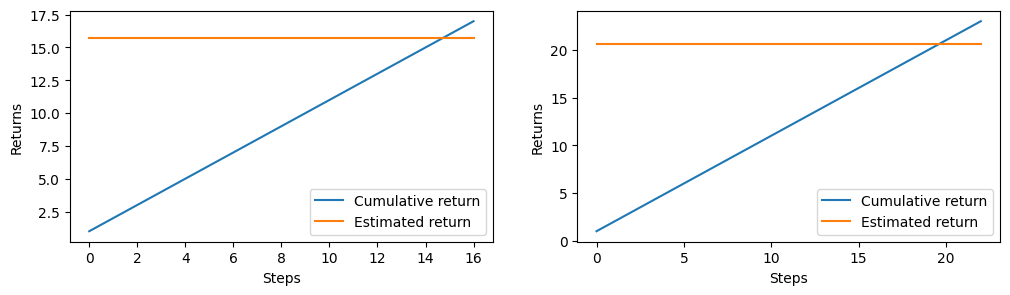

In [38]:
sampled_rew = [list(perform_single_rollout(env = env, agent = policy_gradients_agent, episode_nb = 1)[2]) for _ in range(2)]
returns = policy_gradients_agent.estimate_returns(sampled_rew)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize = (12, 3))

#axes[0, 0].plot(sampled_rew[0])
rewards = sampled_rew[0]
axes[0].plot([sum(rewards[:t+1]) for t in range(len(rewards))], label = 'Cumulative return')
axes[0].plot(returns[:len(sampled_rew[0])], label = 'Estimated return')
#axes[0, 1].plot(returns[:len(sampled_rew[0])])
axes[0].set(xlabel = 'Steps', ylabel = 'Returns')
axes[0].legend()

#axes[1].plot(sampled_rew[1], label = 'Return')
rewards = sampled_rew[1]
axes[1].plot([sum(rewards[:t+1]) for t in range(len(rewards))], label = 'Cumulative return')
axes[1].plot(returns[-len(sampled_rew[1]):], label = 'Estimated return')
axes[1].set(xlabel = 'Steps', ylabel = 'Returns')
#axes[1, 1].plot(returns[-len(sampled_rew[1]):])
#axes[1, 1].set(xlabel = 'Steps')
axes[1].legend()

#plt.legend()

In [30]:
[sum(sampled_rew[0][:t]) for t in range(len(sampled_rew[0]))]

[0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

In [37]:
[sum(sampled_rew[0][:t+1]) for t in range(len(sampled_rew[0]))]

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

In [36]:
[rew for rew in sampled_rew[0]]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [26]:
sum([rew for rew in sampled_rew[0]])

13.0

In [24]:
sum([sampled_rew[0][t] * (0.99 ** t) for t in range(len(sampled_rew[0]))])

12.247897700103202

In [21]:
returns

array([13.994164, 13.994164, 13.994164, 13.994164, 13.994164, 13.994164,
       13.994164, 13.994164, 13.994164, 13.994164, 13.994164, 13.994164,
       13.994164, 13.994164, 13.994164, 22.217865, 22.217865, 22.217865,
       22.217865, 22.217865, 22.217865, 22.217865, 22.217865, 22.217865,
       22.217865, 22.217865, 22.217865, 22.217865, 22.217865, 22.217865,
       22.217865, 22.217865, 22.217865, 22.217865, 22.217865, 22.217865,
       22.217865, 22.217865, 22.217865, 22.217865], dtype=float32)